In [3]:
import sklearn

data = sklearn.datasets.fetch_openml('qsar-biodeg', as_frame=True)
data = data.frame

c:\i\mlops\.venv\Lib\site-packages\sklearn\datasets\_openml.py:328: UserWarning: Multiple active versions of the dataset matching the name qsar-biodeg exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=1494
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=46952

  warn(warning_msg)


In [4]:
print(data.shape)
data.head()

(1055, 42)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V33,V34,V35,V36,V37,V38,V39,V40,V41,Class
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,...,0,0,0,2.949,1.591,0,7.253,0,0,2
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,...,0,0,0,3.315,1.967,0,7.257,0,0,2
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,...,0,0,1,3.076,2.417,0,7.601,0,0,2
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,...,0,0,1,3.046,5.000,0,6.690,0,0,2
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,...,0,0,0,3.351,2.405,0,8.003,0,0,2


### Convertir la columna class a 0/1 (Binaria)

In [5]:
data['Class'] = data['Class'].map({'1': 0, '2': 1}) # Convert to binary labels
data['Class'].unique()
data['Class'] = data['Class'].astype(int)

### Dividir en entrenamiento y prueba

In [6]:
X = data.drop(columns=['Class'])
y = data['Class']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(844, 41) (211, 41)


## Escala de datos con StandardScaler

In [8]:
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelo Random Forest Classifier

In [ ]:
import mlflow

mlflow.set_experiment("QSAR")

2025/11/03 18:42:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 18:43:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test Accuracy: 0.8625592417061612


In [ ]:
with mlflow.start_run():
    C = 1
    max_iter = 100
    solver = 'liblinear'
    model = sklearn.linear_model.LogisticRegression(C=C, max_iter=max_iter, solver=solver)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # Evaluate the model using accuracy, precision, recall, and F1-score
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    precision = sklearn.metrics.precision_score(y_test, y_pred)
    recall = sklearn.metrics.recall_score(y_test, y_pred)
    f1 = sklearn.metrics.f1_score(y_test, y_pred)
    
    mlflow.log_param("C", C)
    mlflow.log_param("max_iter", max_iter)
    mlflow.log_param("solver", solver)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    
    mlflow.sklearn.log_model(model, "random_forest_model")
    
    print(f"Test Accuracy: {accuracy}")

## Modelo Red Neuronal con Tensorflow y Keras

In [ ]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

mlflow.tensorflow.autolog()

with mlflow.start_run():
    
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.05),
                  loss='binary_crossentropy',
                  metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
        
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

## Comparación de modelos

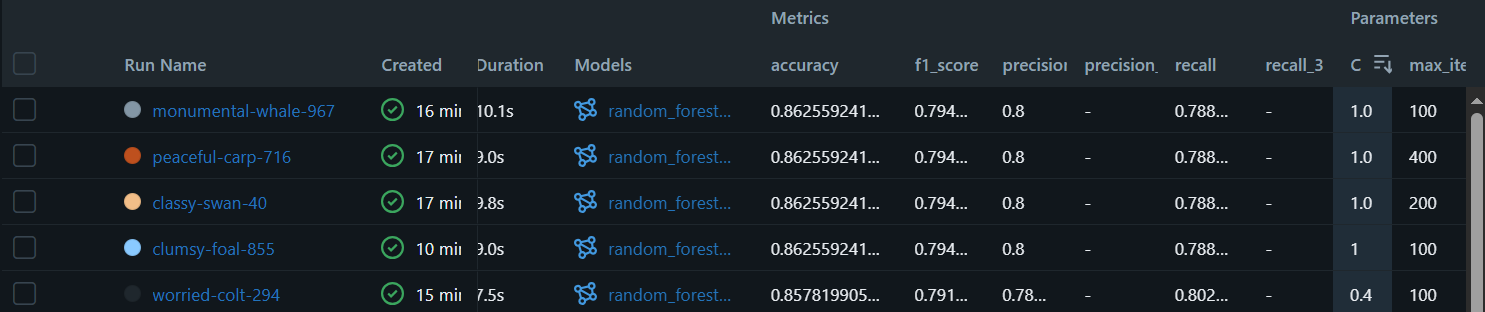

In [1]:
import mlflow

experiment = mlflow.get_experiment_by_name("QSAR")
experiment_id = experiment.experiment_id

runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
    filter_string="",
    order_by=["metrics.accuracy DESC"]
)

print(runs[['run_id', 'metrics.accuracy', 'metrics.precision', 'metrics.recall', 'metrics.f1_score', 'params.C', 'params.max_iter', 'params.solver']])

                              run_id  metrics.accuracy  metrics.precision  \
0   3e84cf57d6e941869df552cca143e66c          0.920616                NaN   
1   dca8d9b919c24b59935545b55b247550          0.895735                NaN   
2   f054391b285c482c9a336190fae77b81          0.872038           0.892857   
3   42ec776b79a4488e95961338bf037ac5          0.862559           0.800000   
4   1b97233202794bc89076cea4056bedab          0.862559           0.800000   
5   adab463ba59545219e0eb07f0de5f768          0.862559           0.800000   
6   e9ef45fbad314e2b80343ff13f06424b          0.862559           0.800000   
7   5368f7ecba55464d82ffe1eaaef9eee6          0.857820           0.780822   
8   2af0bea11c0b4c6c92a87d3e9e906e88          0.838863           0.746667   
9   9743173a4a554163a2965e6cf92aabe0               NaN                NaN   
10  4eb54f47ef5a4adab68071b8fc29a6af               NaN                NaN   
11  4eacfb10487b4d5eb3f7dc369c228872               NaN                NaN   

## Paso 8.

In [ ]:
import mlflow
import mlflow.sklearn
import mlflow.tensorflow

mlflow.autolog()
mlflow.sklearn.autolog()
mlflow.tensorflow.autolog()

In [9]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

mlflow.set_experiment("QSAR")

kf = KFold(n_splits=3, shuffle=True, random_state=42)

with mlflow.start_run() as parent_run:
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        with mlflow.start_run(run_name=f"Fold_{fold+1}", nested=True):
            model = LogisticRegression(C=1.0, max_iter=200, solver='liblinear')
            model.fit(X_train_fold, y_train_fold)
            acc = model.score(X_val_fold, y_val_fold)
            mlflow.log_metric("accuracy", acc)
            print(f"Fold {fold+1} Accuracy: {acc:.4f}")

Fold 1 Accuracy: 0.8546
Fold 2 Accuracy: 0.8719
Fold 3 Accuracy: 0.8541
